In [108]:
import os
import re

import anndata
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from umap import UMAP
from sklearn.preprocessing import StandardScaler


In [2]:
import torch
from torchvision import datasets, transforms

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [58]:
import violet
from violet.utils import image_classification_dataloaders, load_pretrained_model
from violet.utils.attention import plot_image_attention
from violet.utils.model import predict
from violet.utils.dataloaders import get_dataloader, listfiles

In [6]:
img_dir = '/home/estorrs/spatial-analysis/data/breast/model_inputs_06092021/he_imgs_v2'
weights = '/home/estorrs/dino/outputs/test_run_5_brca_good_only/checkpoint0480.pth'

In [7]:
train_dataloader, val_dataloader = image_classification_dataloaders(img_dir)

/home/estorrs/miniconda3/envs/violet/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [61]:
model = load_pretrained_model(weights)
model = model.cuda()

Take key teacher in provided checkpoint dict
Pretrained weights found at /home/estorrs/dino/outputs/test_run_5_brca_good_only/checkpoint0480.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [62]:
fps = sorted(listfiles(img_dir, regex='.jpeg$'))
len(fps)

210756

/home/estorrs/miniconda3/envs/violet/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


(<Figure size 720x288 with 18 Axes>,
 array([[<AxesSubplot:title={'center':'head 0'}, ylabel='overlay'>,
         <AxesSubplot:title={'center':'head 1'}>,
         <AxesSubplot:title={'center':'head 2'}>,
         <AxesSubplot:title={'center':'head 3'}>,
         <AxesSubplot:title={'center':'head 4'}>,
         <AxesSubplot:title={'center':'head 5'}>],
        [<AxesSubplot:ylabel='image'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='attention'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

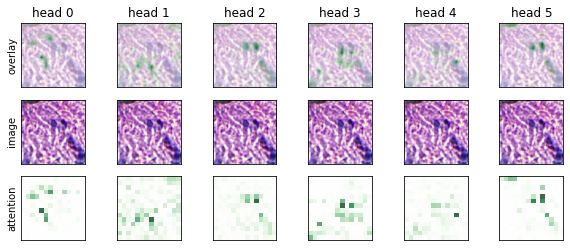

In [63]:
plot_image_attention(fps[0], model)

(<Figure size 720x288 with 3 Axes>,
 array([<AxesSubplot:ylabel='overlay'>, <AxesSubplot:ylabel='image'>,
        <AxesSubplot:ylabel='attention'>], dtype=object))

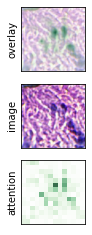

In [64]:
plot_image_attention(fps[0], model, display='mean')

In [103]:
dataloader = get_dataloader(img_dir, batch_size=1024, shuffle=False)
embs = predict(dataloader, model)
embs.shape

(210756, 384)

In [110]:
x = UMAP(n_components=2).fit_transform(embs)

In [116]:
adata = anndata.AnnData(X=embs)
adata.obs.index = [s.split('/')[-1].split('.')[0] for s, _ in dataloader.dataset.samples]
adata.obs['sample'] = ['_'.join(s.split('_')[:-1]) for s in adata.obs.index]
adata.obsm['X_umap_emb'] = x
adata

AnnData object with n_obs × n_vars = 210756 × 384
    obs: 'sample'
    obsm: 'X_umap_emb'

... storing 'sample' as categorical


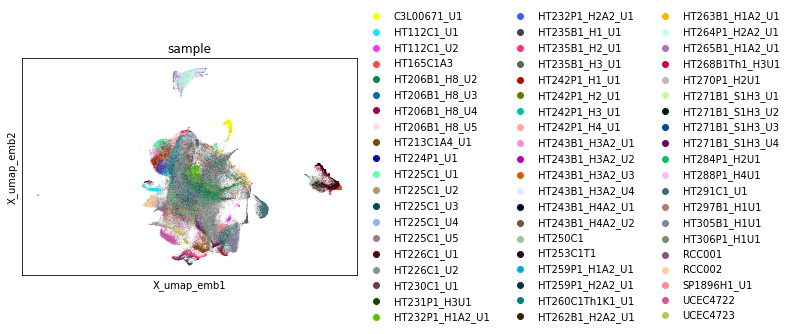

In [117]:
sc.pl.embedding(adata, basis='X_umap_emb', color=['sample'])

In [113]:
fmap = pd.read_csv('/home/estorrs/spatial-analysis/data/sample_map.txt', sep='\t', index_col=0)
fmap

,spaceranger_output,highres_image,disease
sample_id,,,
HT206B1_H8_U2,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
HT206B1_H8_U3,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
HT206B1_H8_U4,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
HT206B1_H8_U5,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
HT206B1_H8_Bn,/data/spatial_transcriptomics/spaceranger_outp...,NaN,brca
...,...,...,...
NMK_20201012,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/m...,mouse_kidney
AKICL_14w,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/m...,mouse_kidney
AKI_M_14w,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/m...,mouse_kidney


... storing 'disease' as categorical


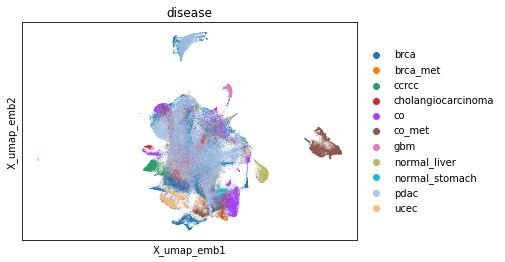

In [121]:
adata.obs['disease'] = [fmap.loc[x, 'disease'] for x in adata.obs['sample']]
sc.pl.embedding(adata, basis='X_umap_emb', color=['disease'])

In [137]:
# lets do co_met
keep = ['co', 'co_met']
co = adata[[True if x in keep else False for x in adata.obs['disease']]].copy()
co

AnnData object with n_obs × n_vars = 44151 × 384
    obs: 'sample', 'disease'
    uns: 'sample_colors', 'disease_colors'
    obsm: 'X_umap_emb'

In [131]:
index = []
data = None
for i, row in fmap.iterrows():
    if row['disease'] in keep:
        a = sc.read_visium(row['spaceranger_output'])
        a.var_names_make_unique()
        
        index += [f'{i}_{x}' for x in a.obs.index]

        if data is None:
            data = a.X.toarray().astype(int)
        else:
            data = np.concatenate((data, a.X.toarray().astype(int)), axis=0)
len(index), data.shape

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

(44151, (44151, 36601))

HT112C1_U1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


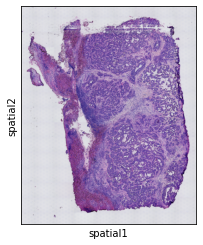

HT112C1_U2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


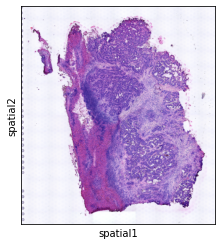

HT225C1_U1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


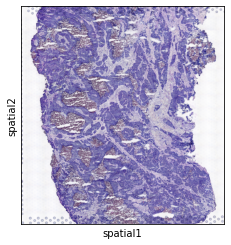

HT225C1_U2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


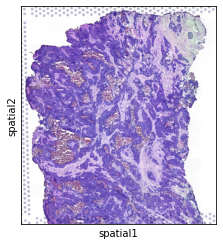

HT225C1_U3


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


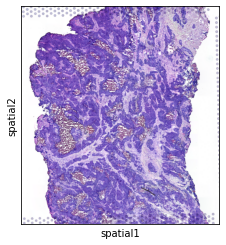

HT225C1_U4


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


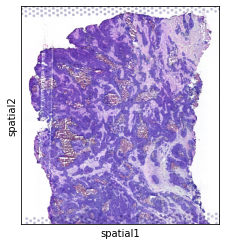

HT225C1_U5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


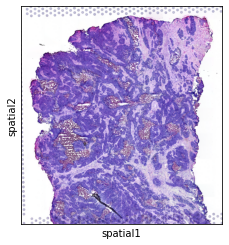

HT230C1_U1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


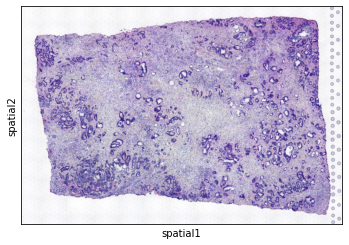

HT260C1Th1K1_U1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


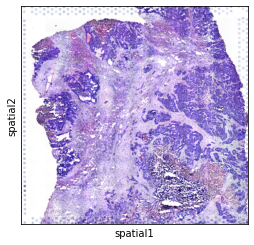

HT213C1A4_U1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


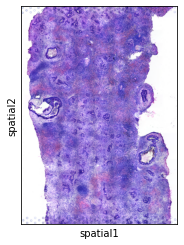

HT165C1A3


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


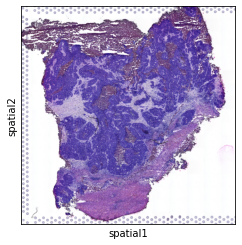

HT250C1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


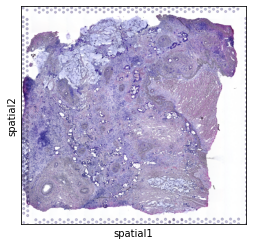

HT253C1T1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


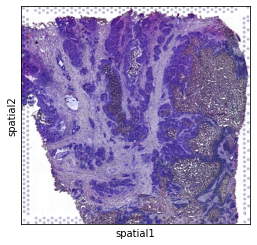

In [130]:
for i, row in fmap.iterrows():
    if row['disease'] in keep:
        print(i)
        a = sc.read_visium(row['spaceranger_output'])
        a.var_names_make_unique()
        sc.pl.spatial(a)

In [144]:
s_id = 'HT112C1_U2'
ref = co[co.obs['sample']==s_id].copy()
sc.pp.pca(ref)
sc.pp.neighbors(ref)
sc.tl.umap(ref)
sc.tl.leiden(ref)
new = []
for s in sorted(set(co.obs['sample'])):
    small = co[co.obs['sample']==s].copy()
    if s!=s_id:
        sc.tl.ingest(small, ref, obs=['leiden'])
        new.append(small)
new.append(ref)
corrected = anndata.concat(new)
corrected

AnnData object with n_obs × n_vars = 44151 × 384
    obs: 'sample', 'disease', 'leiden'
    obsm: 'X_umap_emb', 'X_pca', 'X_umap'

... storing 'sample' as categorical
... storing 'disease' as categorical


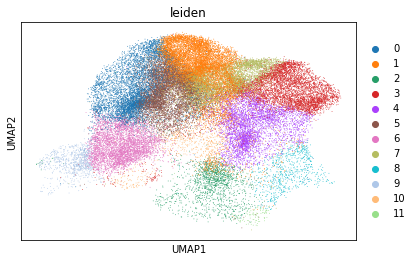

In [145]:
sc.pl.umap(corrected, color='leiden')